# Modeling<a id='5_Modeling'></a>

## Imports<a id='5.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [3]:
# Keeping the default settings and only changing the width of the current notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load Model<a id='5.4_Load_Model'></a>

In [6]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = 'C:/Users/aktha/Desktop/Future/GOALLLLL/DataScienceGuidedCapstone/data/models/ski_resort_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## Load Data<a id='5.5_Load_Data'></a>

In [7]:
ski_data = pd.read_csv('C:/Users/aktha/Desktop/Future/GOALLLLL/DataScienceGuidedCapstone/data/data/ski_data_step3_features.csv')

In [8]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [9]:
big_mountain.T

,124
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastSixes,0
fastQuads,3
quad,2


## Refit Model On All Available Data (excluding Big Mountain)<a id='5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain)'></a>

This next step requires some careful thought. We want to refit the model using all available data. But should we include Big Mountain data? On the one hand, we are _not_ trying to estimate model performance on a previously unseen data sample, so theoretically including Big Mountain data should be fine. One might first think that including Big Mountain in the model training would, if anything, improve model performance in predicting Big Mountain's ticket price. But here's where our business context comes in. The motivation for this entire project is based on the sense that Big Mountain needs to adjust its pricing. One way to phrase this problem: we want to train a model to predict Big Mountain's ticket price based on data from _all the other_ resorts! We don't want Big Mountain's current price to bias this. We want to calculate a price based only on its competitors.

In [10]:
X = ski_data.loc[ski_data.Name != "Big Mountain Resort", model.X_columns]
y = ski_data.loc[ski_data.Name != "Big Mountain Resort", 'AdultWeekend']

In [11]:
len(X), len(y)

(276, 276)

In [12]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=69, n_jobs=None,
                                      

In [67]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results

{'fit_time': array([0.24301386, 0.23899293, 0.23200274, 0.17499781, 0.24299812]),
 'score_time': array([0.00700855, 0.00400138, 0.00602293, 0.00399995, 0.00699782]),
 'test_score': array([-12.10337215,  -9.28661397, -11.41279578,  -8.06408169,
        -11.05864559])}

In [14]:
cv_results['test_score']

array([-12.10337215,  -9.28661397, -11.41279578,  -8.06408169,
       -11.05864559])

In [71]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(10.3851018351214, 1.487015739861695)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

## Calculate Expected Big Mountain Ticket Price From The Model<a id='5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model'></a>

In [16]:
X_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", model.X_columns]
y_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", 'AdultWeekend']

In [17]:
bm_pred = model.predict(X_bm).item()

In [18]:
y_bm = y_bm.values.item()

In [19]:
print(f'Big Mountain Resort modelled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}, this suggests there is room for an increase.')

Big Mountain Resort modelled price is $94.22, actual price is $81.00.
Even with the expected mean absolute error of $10.39, this suggests there is room for an increase.


This result should be looked at optimistically and doubtfully! The validity of our model lies in the assumption that other resorts accurately set their prices according to what the market (the ticket-buying public) supports. The fact that our resort seems to be charging that much less that what's predicted suggests our resort might be undercharging. 
But if ours is mispricing itself, are others? It's reasonable to expect that some resorts will be "overpriced" and some "underpriced." Or if resorts are pretty good at pricing strategies, it could be that our model is simply lacking some key data? Certainly we know nothing about operating costs, for example, and they would surely help.

## Big Mountain Resort In Market Context<a id='5.8_Big_Mountain_Resort_In_Market_Context'></a>

Features that came up as important in the modeling (not just our final, random forest model) included:
* vertical_drop
* Snow Making_ac
* total_chairs
* fastQuads
* Runs
* LongestRun_mi
* trams
* SkiableTerrain_ac

A handy glossary of skiing terms can be found on the [ski.com](https://www.ski.com/ski-glossary) site. Some potentially relevant contextual information is that vertical drop, although nominally the height difference from the summit to the base, is generally taken from the highest [_lift-served_](http://verticalfeet.com/) point.

It's often useful to define custom functions for visualizing data in meaningful ways. The function below takes a feature name as an input and plots a histogram of the values of that feature. It then marks where Big Mountain sits in the distribution by marking Big Mountain's value with a vertical line using `matplotlib`'s [axvline](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvline.html) function. It also performs a little cleaning up of missing values and adds descriptive labels and a title.

In [72]:
#Add code to the `plot_compare` function that displays a vertical, dashed line
#on the histogram to indicate Big Mountain's position in the distribution
#Hint: plt.axvline() plots a vertical line, its position for 'feature1'
#would be `big_mountain['feature1'].values, we'd like a red line, which can be
#specified with c='r', a dashed linestyle is produced by ls='--',
#and it's nice to give it a slightly reduced alpha value, such as 0.8.
#Don't forget to give it a useful label (e.g. 'Big Mountain') so it's listed
#in the legend.
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Big Mountain's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if state is None:
        ski_x = ski_data[feat_name]
    else:
        ski_x = ski_data.loc[ski_data.state == state, feat_name]
    ski_x = ski_x[np.isfinite(ski_x)]
    plt.hist(ski_x, bins=30, edgecolor='white')
    plt.grid(True)   
    plt.axvline(x=big_mountain[feat_name].values, c='r', ls='--', alpha=0.8, label='Big Mountain')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()

### Ticket price<a id='5.8.1_Ticket_price'></a>

Look at where Big Mountain sits overall amongst all resorts for price and for just other resorts in Montana.

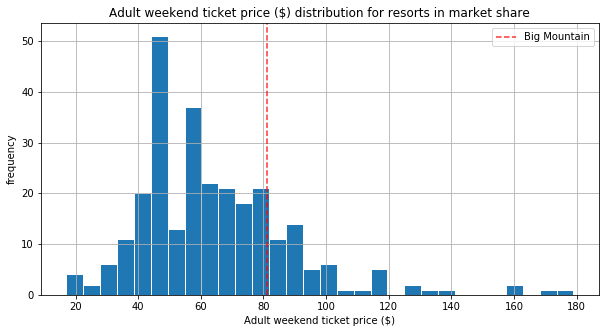

In [73]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($)')

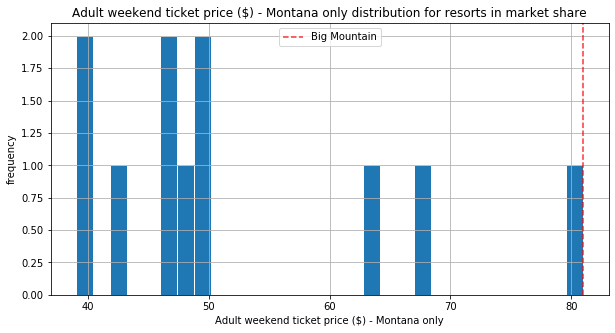

In [74]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($) - Montana only', state='Montana')

### Vertical drop<a id='5.8.2_Vertical_drop'></a>

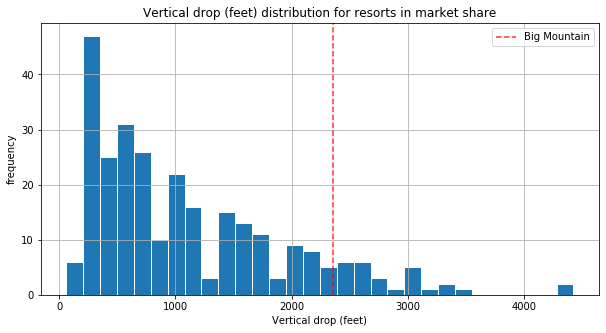

In [75]:
plot_compare('vertical_drop', 'Vertical drop (feet)')

Big Mountain is doing well for vertical drop, but there are still quite a few resorts with a greater drop.

### Snow making area<a id='5.8.3_Snow_making_area'></a>

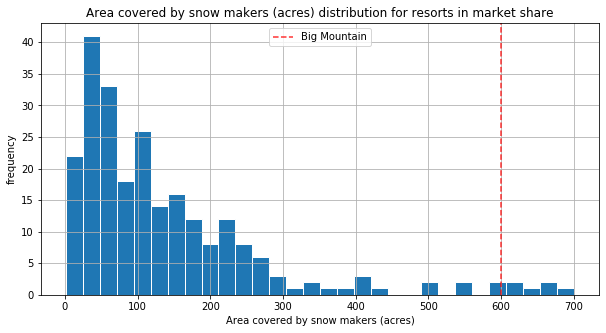

In [76]:
plot_compare('Snow Making_ac', 'Area covered by snow makers (acres)')

Big Mountain is very high up the league table of snow making area.

### Total number of chairs<a id='5.8.4_Total_number_of_chairs'></a>

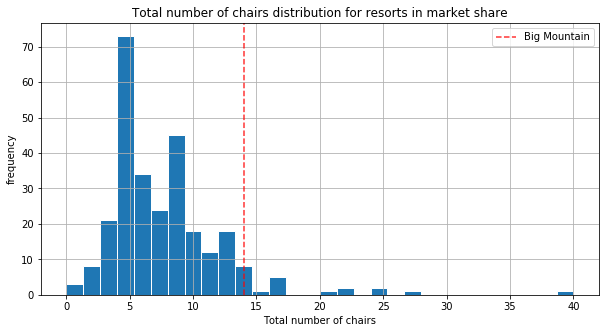

In [77]:
plot_compare('total_chairs', 'Total number of chairs')

Big Mountain has amongst the highest number of total chairs, resorts with more appear to be outliers.

### Fast quads<a id='5.8.5_Fast_quads'></a>

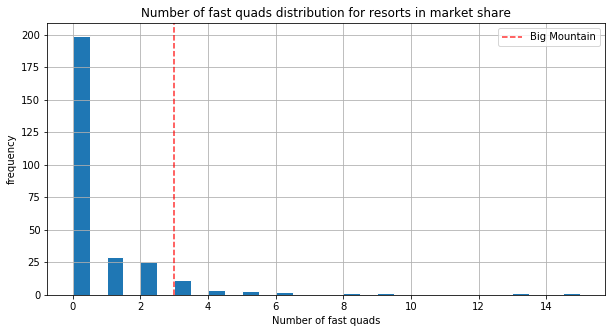

In [78]:
plot_compare('fastQuads', 'Number of fast quads')

Most resorts have no fast quads. Big Mountain has 3, which puts it high up that league table. There are some values  much higher, but they are rare.

### Runs<a id='5.8.6_Runs'></a>

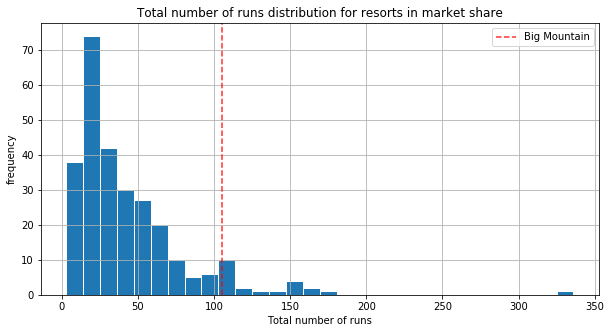

In [79]:
plot_compare('Runs', 'Total number of runs')

Big Mountain compares well for the number of runs. There are some resorts with more, but not many.

### Longest run<a id='5.8.7_Longest_run'></a>

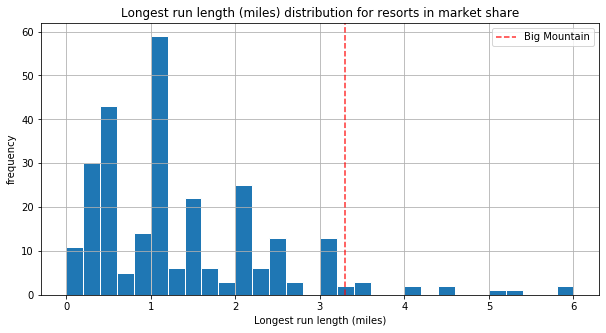

In [80]:
plot_compare('LongestRun_mi', 'Longest run length (miles)')

Big Mountain has one of the longest runs. Although it is just over half the length of the longest, the longer ones are rare.

### Trams<a id='5.8.8_Trams'></a>

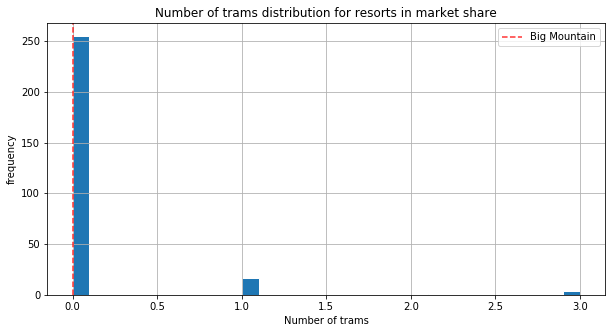

In [81]:
plot_compare('trams', 'Number of trams')

The vast majority of resorts, such as Big Mountain, have no trams.

### Skiable terrain area<a id='5.8.9_Skiable_terrain_area'></a>

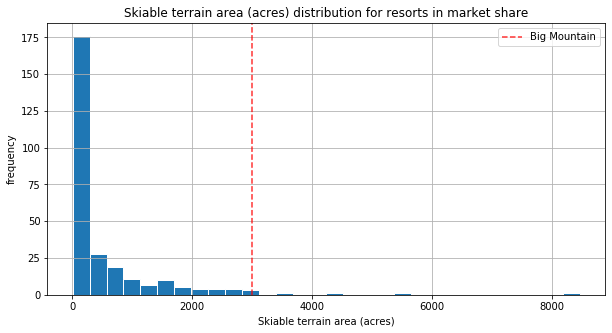

In [82]:
plot_compare('SkiableTerrain_ac', 'Skiable terrain area (acres)')

Big Mountain is amongst the resorts with the largest amount of skiable terrain.

## Modeling scenarios<a id='5.9_Modeling_scenarios'></a>

Big Mountain Resort has been reviewing potential scenarios for either cutting costs or increasing revenue (from ticket prices). Ticket price is not determined by any set of parameters; the resort is free to set whatever price it likes. However, the resort operates within a market where people pay more for certain facilities, and less for others. Being able to sense how facilities support a given ticket price is valuable business intelligence. This is where the utility of our model comes in.

The business has shortlisted some options:
1. Permanently closing down up to 10 of the least used runs. This doesn't impact any other resort statistics.
2. Increase the vertical drop by adding a run to a point 150 feet lower down but requiring the installation of an additional chair lift to bring skiers back up, without additional snow making coverage
3. Same as number 2, but adding 2 acres of snow making cover
4. Increase the longest run by 0.2 mile to boast 3.5 miles length, requiring an additional snow making coverage of 4 acres

The expected number of visitors over the season is 350,000 and, on average, visitors ski for five days. Assume the provided data includes the additional lift that Big Mountain recently installed.

In [46]:
expected_visitors = 350_000

In [47]:
all_feats = ['vertical_drop', 'Snow Making_ac', 'total_chairs', 'fastQuads', 
             'Runs', 'LongestRun_mi', 'trams', 'SkiableTerrain_ac']
big_mountain[all_feats]

,vertical_drop,Snow Making_ac,total_chairs,fastQuads,Runs,LongestRun_mi,trams,SkiableTerrain_ac
124,2353,600.0,14,3,105.0,3.3,0,3000.0


In [48]:
#In this function, copy the Big Mountain data into a new data frame
#(Note we use .copy()!)
#And then for each feature, and each of its deltas (changes from the original),
#create the modified scenario dataframe (bm2) and make a ticket price prediction
#for it. The difference between the scenario's prediction and the current
#prediction is then calculated and returned.
#Complete the code to increment each feature by the associated delta
def predict_increase(features, deltas):
    """Increase in modelled ticket price by applying delta to feature.
    
    Arguments:
    features - list, names of the features in the ski_data dataframe to change
    deltas - list, the amounts by which to increase the values of the features
    
    Outputs:
    Amount of increase in the predicted ticket price
    """
    
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[features] += deltas
    return model.predict(bm2).item() - model.predict(X_bm).item()

### Scenario 1<a id='5.9.1_Scenario_1'></a>

Close up to 10 of the least used runs. The number of runs is the only parameter varying.

In [49]:
[i for i in range(-1, -11, -1)]

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]

In [50]:
runs_delta = [i for i in range(-1, -11, -1)]
price_deltas = [predict_increase(['Runs'], [delta]) for delta in runs_delta]

In [51]:
price_deltas

[0.0,
 -0.4057971014492807,
 -0.6666666666666714,
 -0.6666666666666714,
 -0.6666666666666714,
 -1.2608695652173907,
 -1.2608695652173907,
 -1.2608695652173907,
 -1.7101449275362341,
 -1.7101449275362341]

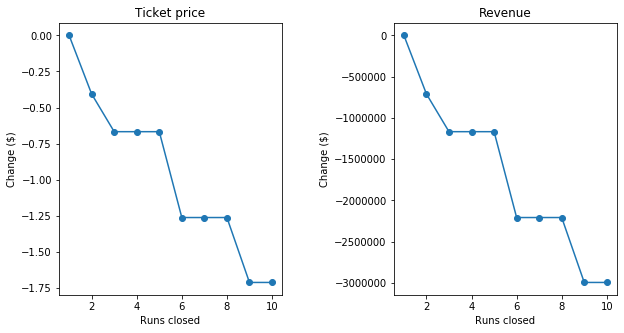

In [88]:
#Create two plots, side by side, for the predicted ticket price change (delta) for each
#condition (number of runs closed) in the scenario and the associated predicted revenue
#change on the assumption that each of the expected visitors buys 5 tickets
#There are two things to do here:
#1 - use a list comprehension to create a list of the number of runs closed from `runs_delta`
#2 - use a list comprehension to create a list of predicted revenue changes from `price_deltas`
runs_closed = [-1 * run for run in runs_delta] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(runs_closed, price_deltas, 'o-')
ax[0].set(xlabel='Runs closed', ylabel='Change ($)', title='Ticket price')
revenue_deltas = [5 * expected_visitors * revenue for revenue in price_deltas] #2
ax[1].plot(runs_closed, revenue_deltas, 'o-')
ax[1].set(xlabel='Runs closed', ylabel='Change ($)', title='Revenue');

The model says closing one run makes no difference. Closing 2 and 3 successively reduces support for ticket price and so revenue. If Big Mountain closes down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price. Increasing the closures down to 6 or more leads to a large drop. 

### Scenario 2<a id='5.9.2_Scenario_2'></a>

In this scenario, Big Mountain is adding a run, increasing the vertical drop by 150 feet, and installing an additional chair lift.

In [91]:
#Call `predict_increase` with a list of the features 'Runs', 'vertical_drop', and 'total_chairs'
#and associated deltas of 1, 150, and 1
ticket2_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs'], [1, 150, 1])
revenue2_increase = 5 * expected_visitors * ticket2_increase

In [92]:
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')

This scenario increases support for ticket price by $8.46
Over the season, this could be expected to amount to $14811594


### Scenario 3<a id='5.9.3_Scenario_3'></a>

In this scenario, you are repeating the previous one but adding 2 acres of snow making.

In [125]:
#Repeat scenario 2 conditions, but add an increase of 2 to `Snow Making_ac`
ticket3_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs', 'Snow Making_ac'], [1, 150, 1, 2])
revenue3_increase = 5 * expected_visitors * ticket3_increase

In [126]:
print(f'This scenario increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

This scenario increases support for ticket price by $9.75
Over the season, this could be expected to amount to $17068841


Such a small increase in the snow making area makes no difference!

### Scenario 4<a id='5.9.4_Scenario_4'></a>

This scenario calls for increasing the longest run by .2 miles and guaranteeing its snow coverage by adding 4 acres of snow making capability.

In [66]:
#Predict the increase from adding 0.2 miles to `LongestRun_mi` and 4 to `Snow Making_ac`
predict_increase(['LongestRun_mi', 'Snow Making_ac'], [0.2, 4])

0.0

No difference whatsoever. Although the longest run feature was used in the linear model, the random forest model (the one we chose because of its better performance) only has longest run way down in the feature importance list. 

## Summary<a id='5.10_Summary'></a>

**Q: 1** Write a summary of the results of modeling these scenarios. Start by starting the current position; how much does Big Mountain currently charge? What does your modelling suggest for a ticket price that could be supported in the marketplace by Big Mountain's facilities? How would you approach suggesting such a change to the business leadership? Discuss the additional operating cost of the new chair lift per ticket (on the basis of each visitor on average buying 5 day tickets) in the context of raising prices to cover this. For future improvements, state which, if any, of the modeled scenarios you'd recommend for further consideration. Suggest how the business might test, and progress, with any run closures.

#### A:   Summary of the results of modeling these scenarios:

1. How much does Big Mountain currently charge?
   * Current price is $81.00.
   
1. What does your modelling suggest for a ticket price that could be supported in the marketplace by Big Mountain's facilities?
   * Big Mountain Resort modelled price is $94.22.
    
1. How would you approach suggesting such a change to the business leadership? Big Mountain Resort initially expressed a desire for some guidance to select better Ticket price to achieve an offset of their recent additional operating cost by $1,540,000 (New Chair lift) by either reducing cost without reducing Ticket Price or increasing Ticket Price:
   1. Reduce Operating cost by closing some of the used Runs at Big Mountain Resort, taking into considerations below points:
     * Big Mountain compares well for the number of used runs. In terms of number of Runs: Ranked number 2/11 locally (Montana) and Number 19/277 nationally (USA) so we have the opportunity to reduce the number of runs  
          without impacting the resort place locally and nationally).
     * According to below, our Model says that closing one Run will have no impact on Ticket price or revenue which this will be translated into reducing the resort's operating cost (This option is in line of what the resort has asked for initially).
     * given that we don't have any visibility in the operating cost per run, we're obligated to share below with the Resort what our model saying for reducing runs even though we're lossing Ticket support with   
          below:
          * According to below, our Model says that closing Two Runs reduce support for ticket price and so revenue which this will be translated into reducing the resort's operating cost.
          * According to below, our Model says that closing down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price which this will be translated into reducing the resort's    
               operating cost.
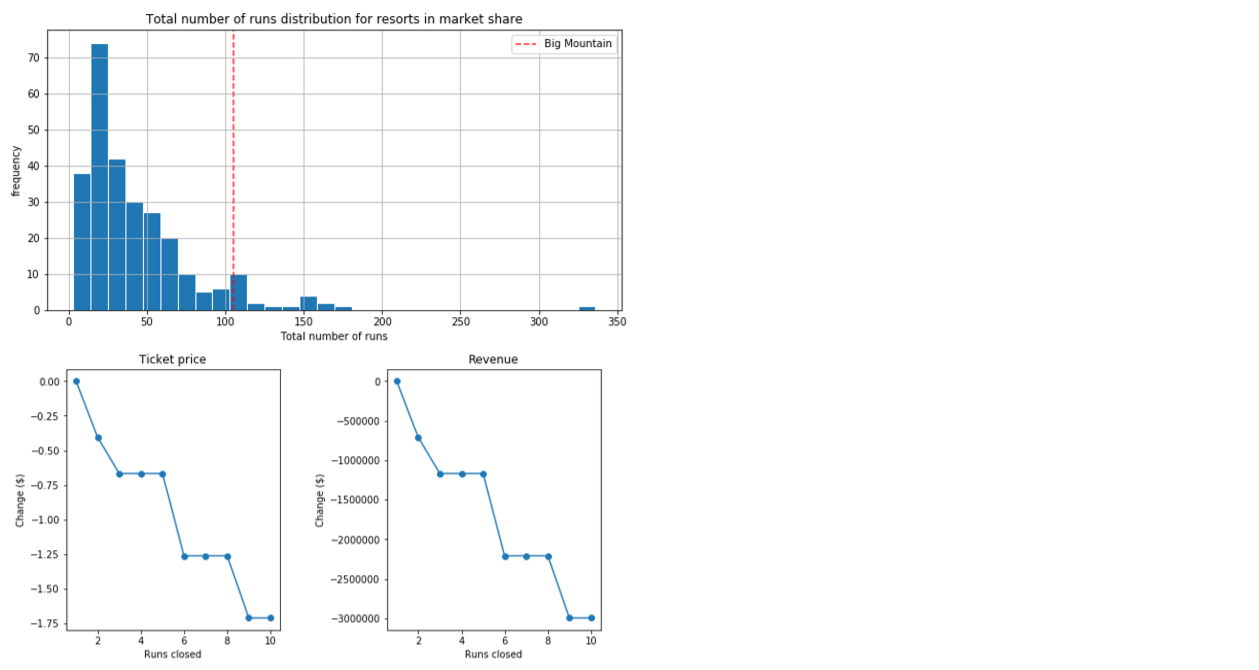     

   1. Increase Ticket price thus increasing revenue: 
     * Our Model says if we increased the vertical drop by 150 feets this will increase the Ticket Price by 10.63*%* from 81.00 to 89.61 US Dollars resulting in reveune increase by 15,065,471 US Dollars however:
     * increasing the vertical drop will require adding a new chair lift (Operating Cost $1,540,000 for this season) also we need an addition run (Cost is Not given).
 
   

## Further work<a id='5.11_Further_work'></a>

**Q: 2** What next? Highlight any deficiencies in the data that hampered or limited this work. The only price data in our dataset were ticket prices. You were provided with information about the additional operating cost of the new chair lift, but what other cost information would be useful? Big Mountain was already fairly high on some of the league charts of facilities offered, but why was its modeled price so much higher than its current price? Would this mismatch come as a surprise to the business executives? How would you find out? Assuming the business leaders felt this model was useful, how would the business make use of it? Would you expect them to come to you every time they wanted to test a new combination of parameters in a scenario? We hope you would have better things to do, so how might this model be made available for business analysts to use and explore?

**A: 2** Your answer here

1. Missing important data:
   * Ticket Price in weekdays: I think it's very important to have visibility to Ticket price during the weekeday in order to see if we need to adjust in order to attract more visitors during off-peak time.
   * Operating cost: we're missing the operating cost for Runs, snow makers - The information is useful per below:
     * Run Operating cose: knowing how much the operating cost per run will allow us to know if have the room to close some of the these runs to offset what ever we save from operating cost compared to how much we can loss in Ticket price.
     * Snow Makers Operating cost: knowing how much the operating cost per snow maker will allow us to know if have the room  to add more snow makers to offset what ever revenue addition we can generate by adding more vertical drop.
2. Another interesting question is why Big Mountain is currently priced much lower than the predicted model. Is the market in Montana unable to support an increased ticket price? For example, perhaps the current customer base values low costs over superior facilities. The current business leaders obviously see that there is an opportunity for price adjustment, so the model may not come as a surprise. For future use, the model could be used to generate a recurring report or potentially incorporated into an application that would allow users to set their own parameters and view the resulting prediction.